### MRI Brain Tumour Classifier, based on Google's Mobilenetv3 Model
References:
- https://blog.research.google/2019/11/introducing-next-generation-on-device.html
- https://www.kaggle.com/models/google/mobilenet-v3/frameworks/tensorFlow2
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.tensorflow.org/tutorials/load_data/images

Found 480 files belonging to 4 classes.
Using 384 files for training.
Found 480 files belonging to 4 classes.
Using 96 files for validation.


2024-05-28 18:49:25.257847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-28 18:49:25.313479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


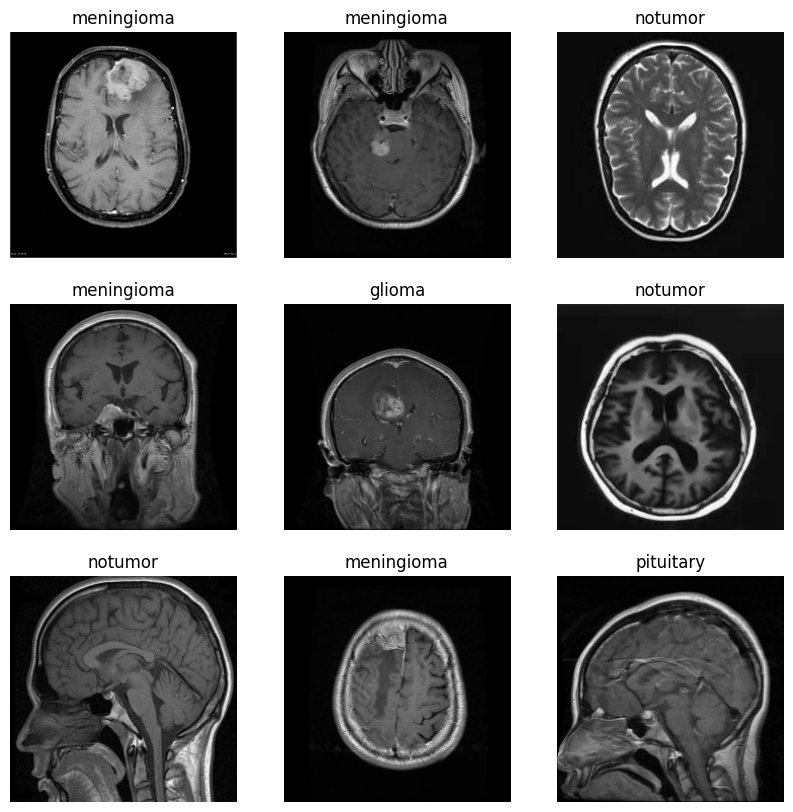

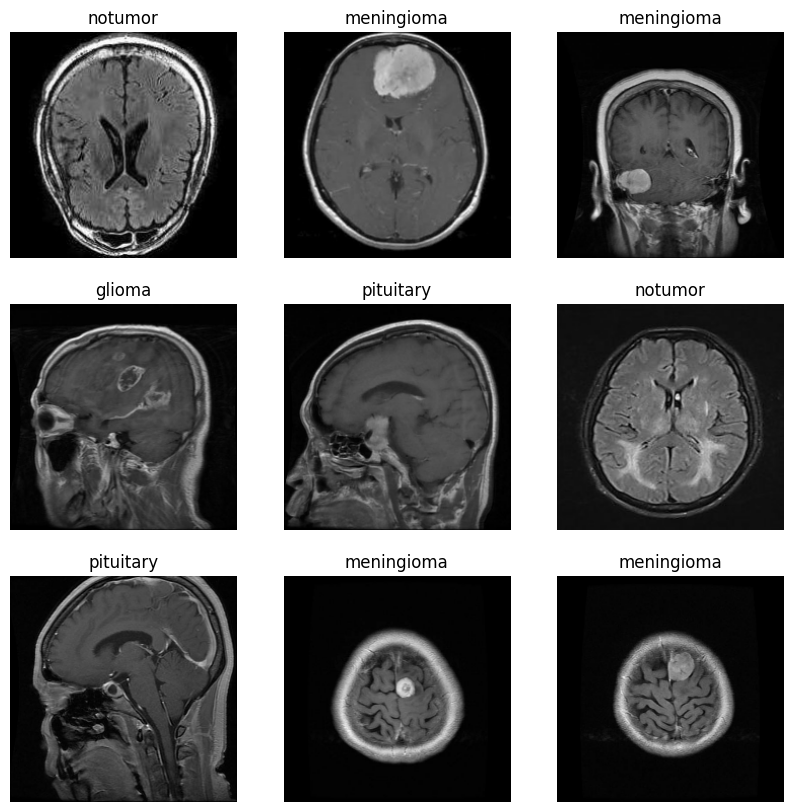

In [1]:
from utils import *

""" Dataset Preparations """
# Parameters
img_batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)
img_shape = img_size + (3,)

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=19032024,
  image_size=(img_height, img_width),
  batch_size=img_batch_size)

# Validation (test) dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=19032024,
  image_size=(img_height, img_width),
  batch_size=img_batch_size)

# Get class names
class_names = train_ds.class_names
class_names = val_ds.class_names

# Enable buffered prefetching to overlap data preprocessing and model execution during training, to speed up access to dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Normalise image tensors' RGB channel values from [0, 255] to required [-1, 1] values used by Mobilenet (use preprocess_input function provided by the model instead!)
# normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
# normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Preview datasets
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [2]:
# Initialise base model
base_model = tf.keras.applications.MobileNetV3Small(input_shape=img_shape, include_top=False, weights='imagenet')

# Freeze base model
base_model.trainable = False

""" Create classification head """
# Create NN layers
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),tf.keras.layers.RandomRotation(0.2),tf.keras.layers.RandomZoom(0.2)])
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Create classifier
inputs = keras.Input(shape=img_shape)

# Preprocessing layers
x = data_augmentation(inputs)
x = preprocess_input(x)

# Base model layer, ensure that the model is running in inference mode
x = base_model(x, training=False) 

# Processing layers
x = global_average_layer(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x) # Dropout regularisation to prevent overfitting

# Dense classifier layer for multi-label classification
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)

# Create classification head
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [3]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,108,468 (11.86 MB)

 Trainable params: 2,168,324 (8.27 MB)

 Non-trainable params: 940,144 (3.59 MB)

In [4]:
# Train model
history = model.fit( train_ds, validation_data=val_ds, epochs=100)

# Export model
model.save(MODEL_FILE)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.5233 - loss: 1.4283 - val_accuracy: 0.2500 - val_loss: 3.3231
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.7588 - loss: 0.6449 - val_accuracy: 0.5208 - val_loss: 1.7283
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.8031 - loss: 0.4843 - val_accuracy: 0.6458 - val_loss: 1.7976
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8772 - loss: 0.3299 - val_accuracy: 0.5000 - val_loss: 1.9377
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8752 - loss: 0.3285 - val_accuracy: 0.5729 - val_loss: 1.7141
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9018 - loss: 0.2888 - val_accuracy: 0.6042 - val_loss: 1.4183
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.8892 - loss: 0.2969 - val_accuracy: 0.6354 - val_loss: 1.1753
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8797 - loss: 0.3116 - val_accu

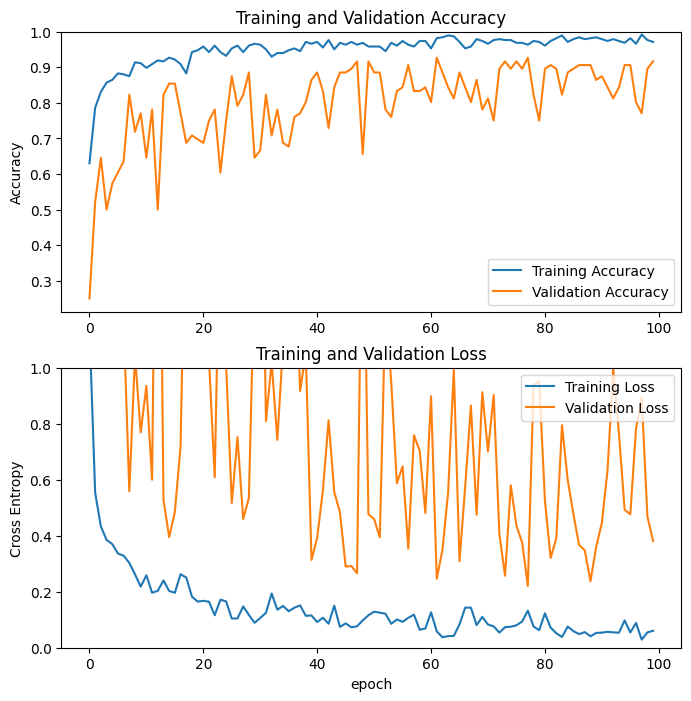

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9154 - loss: 0.3469
Test Accuracy : 0.9166666865348816
Test Loss : 0.3810952603816986


In [5]:
""" Preliminary Model Performance """
# View training metrics across epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(val_ds)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)

In [6]:
""" Model Performance """
# Load images and labels
images, labels, class_names = load_data(DATASET_FOLDER)

# Load the trained model
model = keras.models.load_model(MODEL_FILE)

# Train-Test split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=1234)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# Initialise predictions
list_train_pred = []
list_test_pred = []
for image_path in x_train:
    list_train_pred.append(predict_class(image_path, model, class_names, (224, 224)))
for image_path in x_test:
    list_test_pred.append(predict_class(image_path, model, class_names, (224, 224)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

In [8]:
# Get model's training performance
training_results = classifier_metrics(list(y_train), list_train_pred, print_results=True)

Accuracy: 0.9427083333333334
Precision: 0.9444930069930071
Recall: 0.9427083333333333
F1 Score: 0.9419565217391304
Matthews Correlation Coefficient (MCC): 0.9246819649329358
Cohen's Kappa: 0.9236111111111112
Hamming Loss: 0.057291666666666664

Confusion Matrix:
 [[96  0  0  0]
 [ 8 82  0  6]
 [ 0  6 88  2]
 [ 0  0  0 96]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.92      1.00      0.96        96
  meningioma       0.93      0.85      0.89        96
     notumor       1.00      0.92      0.96        96
   pituitary       0.92      1.00      0.96        96

    accuracy                           0.94       384
   macro avg       0.94      0.94      0.94       384
weighted avg       0.94      0.94      0.94       384





In [9]:
# Get model's test performance
test_results = classifier_metrics(list(y_test), list_test_pred, print_results=True)

Accuracy: 0.9166666666666666
Precision: 0.9245078877565266
Recall: 0.9166666666666666
F1 Score: 0.9148478547036267
Matthews Correlation Coefficient (MCC): 0.8926419488612675
Cohen's Kappa: 0.8888888888888888
Hamming Loss: 0.08333333333333333

Confusion Matrix:
 [[24  0  0  0]
 [ 2 18  0  4]
 [ 0  1 22  1]
 [ 0  0  0 24]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.92      1.00      0.96        24
  meningioma       0.95      0.75      0.84        24
     notumor       1.00      0.92      0.96        24
   pituitary       0.83      1.00      0.91        24

    accuracy                           0.92        96
   macro avg       0.92      0.92      0.91        96
weighted avg       0.92      0.92      0.91        96



